In [1]:
import itertools
import re
import pandas as pd
import pickle
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
%matplotlib inline
from lbs.coiledcoils.parsers import parse_marcoil, parse_deepcoil, parse_pcoils, parse_multicoil2, parse_pcoils_toolkit

In [2]:
from sklearn.metrics import auc, roc_curve
import sklearn
def get_roc(true,predict):
    fpr, tpr, thresh  = roc_curve(true, predict, pos_label=1)
    au = auc(fpr, tpr)
    return fpr, tpr, au

In [3]:
def get_del_indices(df, sdh_df, _class='noncanonical'):
    indices = {}
    for key, value in df.iterrows():
        full_seq = value['sequence']
        sdh_assignment = sdh_df.loc[key, 'periodicity']
        indices[key] = []
        if _class == 'noncanonical':
            starts = [(match.start(), match.end()) for match in re.finditer('C', sdh_assignment)]
            starts2 = [(match.start(), match.end()) for match in re.finditer('1', sdh_assignment)]
            starts = starts+starts2
            if starts:
                for start in starts:
                    indices[key].append(start)
    return indices

In [4]:
def rm_indices(_list, indices):
    res_list = set()
    for indice in indices:
        for i in range(indice[0], indice[1]):
            res_list.add(i)
    new_list = []
    for i in range(0, len(_list)):
        if i not in res_list:
            new_list.append(_list[i])
    return new_list

In [5]:
def get_roc_benchmarks(df, perres=True, del_indices=False):
    true_labels = []
    true_labels_01 = []
    deepcoil_seq_preds = []
    deepcoil_seq_preds_01 = []
    deepcoil_pssm_preds = []
    deepcoil_pssm_preds_01 = []
    marcoil_preds = []
    multicoil2_preds = []
    pcoils_14_preds = []
    pcoils_21_preds = []
    pcoils_28_preds_01 = []
    pcoils_28_preds = []
    coils_14_preds = []
    coils_21_preds = []
    coils_28_preds = []
    cchmm_prof_preds = []
    tmp_list = []
    for key, value in df.iterrows():
        #tmp_list = []
        ### Get true labels
        if perres:
            if not rm_indices:
                for label in list(value['socket_assignment']):
                    true_labels.append(int(label))
            else:
                indices = del_indices[key]
                
                for label in rm_indices(list(df_test_sdh.loc[key, 'periodicity']), indices):
                    if label == 'N':
                        tmp_list.append('1')
                    else:
                        tmp_list.append('0')
                for label in rm_indices(list(value['socket_assignment']), indices):
                    true_labels.append(int(label))
                    true_labels_01.append(str(label))
        else:
            true_labels.append(int(value['cc']))
        ### Get DeepCoil_SEQ preds
        preds = parse_deepcoil('./../2_Benchmark_Other_Methods/deepcoil/deepcoil_seq_probs/%s.out' % key)
        #print(''.join(tmp_list))
        if perres:
            if not rm_indices:
                for pred in preds:
                    deepcoil_seq_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    deepcoil_seq_preds.append(pred)
                    if pred > 0.5:
                        deepcoil_seq_preds_01.append('1')
                    else:
                        deepcoil_seq_preds_01.append('0')
        else:
            deepcoil_seq_preds.append(get_percoil_prob(preds))
            
        preds = value['deepcoil_assignment']
        if perres:
            if not rm_indices:
                for pred in preds:
                    deepcoil_seq_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(list(preds), indices):
                    deepcoil_pssm_preds_01.append(pred)
        ### Get DeepCoil_PSSM preds
        preds = parse_deepcoil('./../2_Benchmark_Other_Methods/deepcoil/deepcoil_pssm_probs/%s.out' % key)
        if perres:
            if not rm_indices:
                for pred in preds:
                    deepcoil_pssm_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    deepcoil_pssm_preds.append(pred)
                    if pred >= 0.5:
                        pass
                        #deepcoil_pssm_preds_01.append('1')
                    else:
                        pass
                        #deepcoil_pssm_preds_01.append('0')
        else:
            deepcoil_pssm_preds.append(get_percoil_prob(preds))
        ### Get Marcoil preds
        preds = parse_marcoil('./../2_Benchmark_Other_Methods/marcoil/results/%s.problist' % key)
        if perres:
            if not rm_indices:
                for pred in preds:
                    marcoil_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    marcoil_preds.append(pred)
        else:
            marcoil_preds.append(get_percoil_prob(preds))
        ### Get PCoils_14 preds
        preds = parse_pcoils_toolkit('./../2_Benchmark_Other_Methods/pcoils/pcoils_toolkit/%s.numerical' % key, window='14')
        if perres:
            if not rm_indices:
                for pred in preds:
                    pcoils_14_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    pcoils_14_preds.append(pred)
        else:
            pcoils_14_preds.append(get_percoil_prob(preds))
        ### Get PCoils_21 preds
        preds = parse_pcoils_toolkit('./../2_Benchmark_Other_Methods/pcoils/pcoils_toolkit/%s.numerical' % key, window='21')
        if perres:
            if not rm_indices:
                for pred in preds:
                    pcoils_21_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    pcoils_21_preds.append(pred)
        else:
            pcoils_21_preds.append(get_percoil_prob(preds))
        ### Get PCoils_28 preds
        preds = parse_pcoils_toolkit('./../2_Benchmark_Other_Methods/pcoils/pcoils_toolkit/%s.numerical' % key, window='28')
        if perres:
            if not rm_indices:
                for pred in preds:
                    pcoils_28_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    pcoils_28_preds.append(pred)
                    if pred > 0.5:
                        pcoils_28_preds_01.append('1')
                    else:
                        pcoils_28_preds_01.append('0')
        else:
            pcoils_28_preds.append(get_percoil_prob(preds))
        ### Get Coils_14 preds
        preds = parse_pcoils('./../2_Benchmark_Other_Methods/coils/results/%s.coils_n14' % key)
        if perres:
            if not rm_indices:
                for pred in preds:
                    coils_14_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    coils_14_preds.append(pred)
        else:
            coils_14_preds.append(get_percoil_prob(preds))
        ### Get Coils_21 preds
        preds = parse_pcoils('./../2_Benchmark_Other_Methods/coils/results/%s.coils_n21' % key)
        if perres:
            if not rm_indices:
                for pred in preds:
                    coils_21_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    coils_21_preds.append(pred)
        else:
            coils_21_preds.append(get_percoil_prob(preds))
        ### Get Coils_28 preds
        preds = parse_pcoils('./../2_Benchmark_Other_Methods/coils/results/%s.coils_n28' % key)
        if perres:
            if not rm_indices:
                for pred in preds:
                    coils_28_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    coils_28_preds.append(pred)
        else:
            coils_28_preds.append(get_percoil_prob(preds))
        ### Get Multicoil2 preds
        preds = parse_multicoil2('./../2_Benchmark_Other_Methods/multicoil2/results/%s.out' % key)
        if perres:
            if not rm_indices:
                for pred in preds:
                    multicoil2_preds.append(pred)
            else:
                indices = del_indices[key]
                for pred in rm_indices(preds, indices):
                    multicoil2_preds.append(pred)
        else:
            multicoil2_preds.append(get_percoil_prob(preds))
        if not perres:
            pred = parse_cch('./../2_Benchmark_Other_Methods/cchmmprof/results/%s.profile' % key)
            cchmm_prof_preds.append(pred)
    results = {}
    results['DeepCoil_SEQ'] = get_roc(true_labels, deepcoil_seq_preds)
    results['DeepCoil_PSSM'] = get_roc(true_labels, deepcoil_pssm_preds)
    results['Marcoil'] = get_roc(true_labels, marcoil_preds)
    results['PCoils_14'] = get_roc(true_labels, pcoils_14_preds)
    results['PCoils_21'] = get_roc(true_labels, pcoils_21_preds)
    results['PCoils_28'] = get_roc(true_labels, pcoils_28_preds)
    results['Coils_14'] = get_roc(true_labels, coils_14_preds)
    results['Coils_21'] = get_roc(true_labels, coils_21_preds)
    results['Coils_28'] = get_roc(true_labels, coils_28_preds)
    results['Multicoil2'] = get_roc(true_labels, multicoil2_preds)
    if not perres:
        results['CCHMM_PROF'] = get_roc(true_labels, cchmm_prof_preds)
    return results

In [6]:
def get_best_pcoils_only(res):
    if res['PCoils_14'][2] > res['PCoils_21'][2] and res['PCoils_14'][2] > res['PCoils_28'][2]:
        res.pop('PCoils_21')
        res.pop('PCoils_28')
    elif res['PCoils_21'][2] > res['PCoils_14'][2] and res['PCoils_21'][2] > res['PCoils_28'][2]:
        res.pop('PCoils_14')
        res.pop('PCoils_28')
    else:
        res.pop('PCoils_14')
        res.pop('PCoils_21')
    if res['Coils_14'][2] > res['Coils_21'][2] and res['Coils_14'][2] > res['Coils_28'][2]:
        res.pop('Coils_21')
        res.pop('Coils_28')
    elif res['Coils_21'][2] > res['Coils_14'][2] and res['Coils_21'][2] > res['Coils_28'][2]:
        res.pop('Coils_14')
        res.pop('Coils_28')
    else:
        res.pop('Coils_14')
        res.pop('Coils_21')
    return res
def get_pcoils21_only(res):
    res.pop('PCoils_14')
    res.pop('PCoils_28')
    res.pop('Coils_14')
    res.pop('Coils_28')
    return res

In [7]:
def get_roc_plot(results):
    plt.figure(figsize=(5,5))
    colors = ['red', 'orange', 'green', 'lightblue', 'darkred', 'darkred', 'darkred', 'black', 'black', 'black',
              'gray']
    order = ['DeepCoil_PSSM', 'DeepCoil_SEQ', 'Marcoil', 'Multicoil2', 'PCoils_14', 'PCoils_21', 'PCoils_28',
             'Coils_28', 'Coils_21', 'Coils_14', 'CCHMM_PROF']
    color_dict = {method: color for method, color in zip(order, colors)}
    for method, data in sorted(results.items(), key=lambda kv: kv[1][2], reverse=True):
        try:
            label='%s (AUC = %0.2f)' % (method, data[2])
            plt.plot(data[0], data[1], label=label, color=color_dict[method], linewidth=2)
        except KeyError:
            pass
    plt.plot([0, 1], [0, 1], color='black', ls='--')
    plt.legend()
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')

### TEST SET

In [8]:
df_test = pickle.load(open('./../4_Train/out/pssm/test_results.p', 'rb'))
df_test_sdh = pd.read_csv('test_set_periodicity_update.csv', index_col=0)

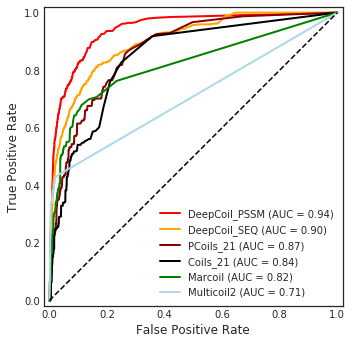

In [9]:
del_indices = get_del_indices(df_test, df_test_sdh, _class='noncanonical')
results = get_roc_benchmarks(df_test, del_indices = del_indices)
results_auc = {}
for key, value in results.items():
    results_auc[key] = value[2]
df = pd.DataFrame.from_dict(results_auc, orient='index')
get_roc_plot(get_pcoils21_only(results))
plt.savefig('TEST_NONCANONICAL.tiff', dpi=300)

## Li2016 TEST SET

In [10]:
df_test = pickle.load(open('./../4_Train/out/pssm/li2016_results.p', 'rb'))
df_test_sdh = pd.read_csv('li_set_periodicity_update.csv', index_col=0)

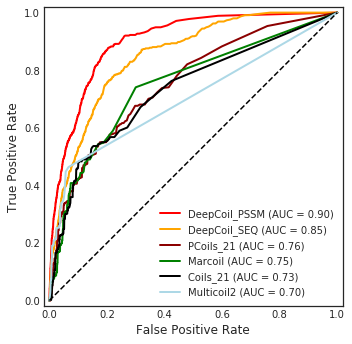

In [11]:
del_indices = get_del_indices(df_test, df_test_sdh, _class='noncanonical')
results = get_roc_benchmarks(df_test, del_indices = del_indices)
results_auc = {}
for key, value in results.items():
    results_auc[key] = value[2]
df = pd.concat([df, pd.DataFrame.from_dict(results_auc, orient='index')], axis=1, sort=True)
get_roc_plot(get_pcoils21_only(results))
plt.savefig('Li2016_NONCANONICAL.tiff', dpi=300)

In [12]:
df.columns = ['Test Set', 'Li (2016) set']

In [13]:
df

,Test Set,Li (2016) set
Coils_14,0.837166,0.747177
Coils_21,0.842685,0.731753
Coils_28,0.785373,0.724426
DeepCoil_PSSM,0.942205,0.900470
DeepCoil_SEQ,0.900083,0.849328
Marcoil,0.817107,0.749230
Multicoil2,0.706976,0.701438
PCoils_14,0.864245,0.731401
PCoils_21,0.869656,0.755187
PCoils_28,0.863307,0.764678
